In [ ]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.stats import levene, ttest_ind


In [2]:
# create instance of taxi environment
env = gym.make('Taxi-v3',render_mode="ansi")

print("Total number of states:", env.observation_space.n)
print("Total number of actions:", env.action_space.n)

Total number of states: 500
Total number of actions: 6


In [3]:
print("Initialized state and mask of allowed actions:")
state, info = env.reset() # reset environment to random state
print(state, info['action_mask'])
print(env.render()) # graphical representation

print("\nRandomly generated (allowed), new state and reward:")
action = env.action_space.sample(info['action_mask'])
state, reward, is_done, _, info = env.step(action=action) # agent interacts with environment
print(action, state, reward)
print(env.render()) # graphical representation

Initialized state and mask of allowed actions:
488 [0 1 0 1 0 0]
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+



Randomly generated (allowed), new state and reward:
1 388 -1
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (North)



In [28]:
def plot_learning_curve(rewards, algorithm="SARSA", window_size=100, figsize=(12, 6), title="Learning Performance in Taxi Environment"):
    """
    Plot learning curves for RL algorithms in the taxi environment.
    
    Parameters:
    -----------
    rewards : list
        List of episode rewards
    algorithm : str
        Name of the algorithm
    window_size : int
        Size of the window for moving average smoothing
    figsize : tuple
        Figure size (width, height)
    title : str
        Plot title
    """
    plt.figure(figsize=figsize)
    
    # Plot raw rewards with transparency
    plt.plot(rewards, label=f"Episode Rewards for {algorithm} (raw)")
    
    # Plot smoothed moving average
    if len(rewards) >= window_size:
        smoothed = np.convolve(rewards, np.ones(window_size)/window_size, mode='valid')
        plt.plot(
            range(window_size-1, len(rewards)), 
            smoothed, 
            color='r', 
            linestyle='-',
            linewidth=2, 
            label=f"Episodes Rewards for {algorithm} (avg over {window_size} episodes)"
        )
    
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    plt.title(title)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    
    return plt.gca()

def plot_average_reward(rewards, algorithm,  figsize=(12, 6), title="Average Reward per Episode", y_lim=(-100, 50)):
    

    # Pre-allocate arrays of the correct size
    n = len(rewards)
    episodes = np.arange(1, n + 1)

    # Calculate cumulative averages in one step
    cumulative_avg = np.cumsum(rewards) / episodes


    # Create x-axis values (number of episodes)
    episodes = np.arange(1, len(rewards) + 1)

    # Create subplots in 2 rows x 3 columns (adding the new zoomed-in views)
    plt.figure(figsize=(12, 6))

    # First Row: Average Reward Plots
    # Original cumulative average rewards
    plt.plot(episodes, cumulative_avg, label="Average Reward", linewidth=2)
    plt.title(f'Average Reward per Episode for {algorithm}', fontsize=12)
    plt.ylabel('Average Reward', fontsize=10)
    plt.xlabel('Training Episodes', fontsize=10)
    plt.ylim(y_lim)
    plt.grid(True, alpha=0.3)
    plt.legend(fontsize=8)

    plt.tight_layout()
    plt.show()

In [5]:
# SARSA Algorithm Implementation
def select_action(state, Q, action_mask=None, epsilon=0.1):
    """
    Select an action using epsilon-greedy policy
    """
    if np.random.rand() < epsilon:
        # Exploration: select a random allowed action
        if action_mask is not None:
            valid_actions = np.where(action_mask == 1)[0]
            return np.random.choice(valid_actions)
        else:
            return np.random.randint(Q.shape[1])
    else:
        # Exploitation: select the action with highest Q-value
        if action_mask is not None:
            # Apply mask to Q-values (set invalid actions to very negative values)
            masked_q_values = np.where(action_mask == 1, Q[state], -np.inf)
            # Select the best action with random choice among all best actions
            return np.random.choice(np.flatnonzero(masked_q_values == masked_q_values.max())) 
            # return np.argmax(masked_q_values)
        else:
            return np.argmax(Q[state])

100%|██████████| 10000/10000 [00:07<00:00, 1374.66it/s]


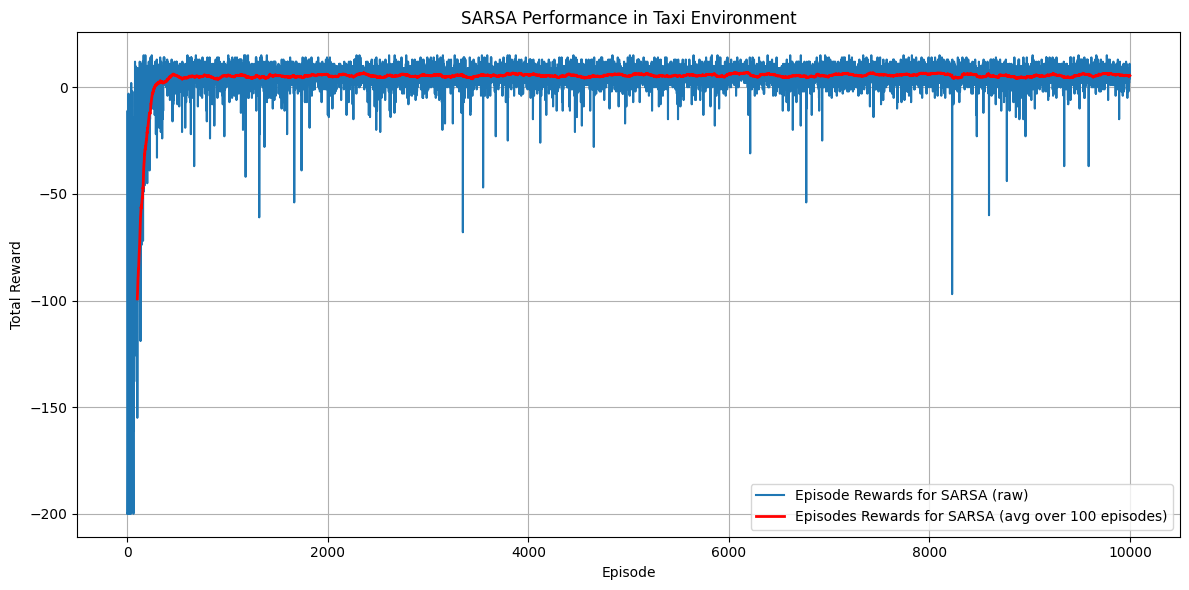

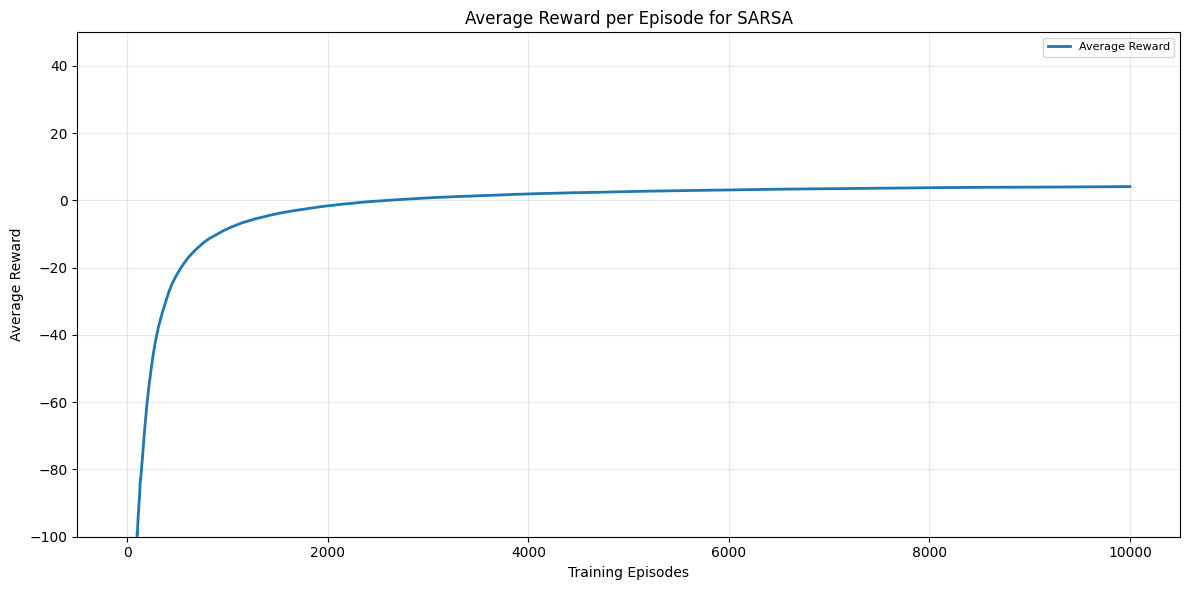

In [29]:
def sarsa(env, alpha = 0.5, gamma = 1, epsilon = 0.1, num_episodes = 10000):
    state_size = env.observation_space.n
    action_size = env.action_space.n
    Q = np.zeros((state_size, action_size))
    rewards_per_episode = []

    for episode in tqdm(range(num_episodes)):
        state, info = env.reset()
        action_mask = info.get('action_mask', np.ones(action_size))
        action = select_action(state, Q, action_mask, epsilon)
        total_reward = 0
        done = False
        
        while not done:
            next_state, reward, terminated, truncated, info = env.step(action)
            done = terminated or truncated
            next_action_mask = info.get('action_mask', np.ones(action_size))
            next_action = select_action(next_state, Q, next_action_mask, epsilon)
            Q[state, action] += alpha * (reward + gamma * Q[next_state, next_action] - Q[state, action])
            state = next_state
            action = next_action
            total_reward += reward
            
            if done:
                break
        
        rewards_per_episode.append(total_reward)
    return Q, rewards_per_episode

sarsa_Q, sarsa_rewards = sarsa(env, alpha=0.5, gamma=1, epsilon=0.1, num_episodes=10000)
plot_learning_curve(sarsa_rewards, algorithm="SARSA", window_size=100, title="SARSA Performance in Taxi Environment")

plot_average_reward(sarsa_rewards, "SARSA", title="Average Reward per Episode for SARSA", y_lim=(-100, 50))

    


100%|██████████| 10000/10000 [00:08<00:00, 1242.36it/s]


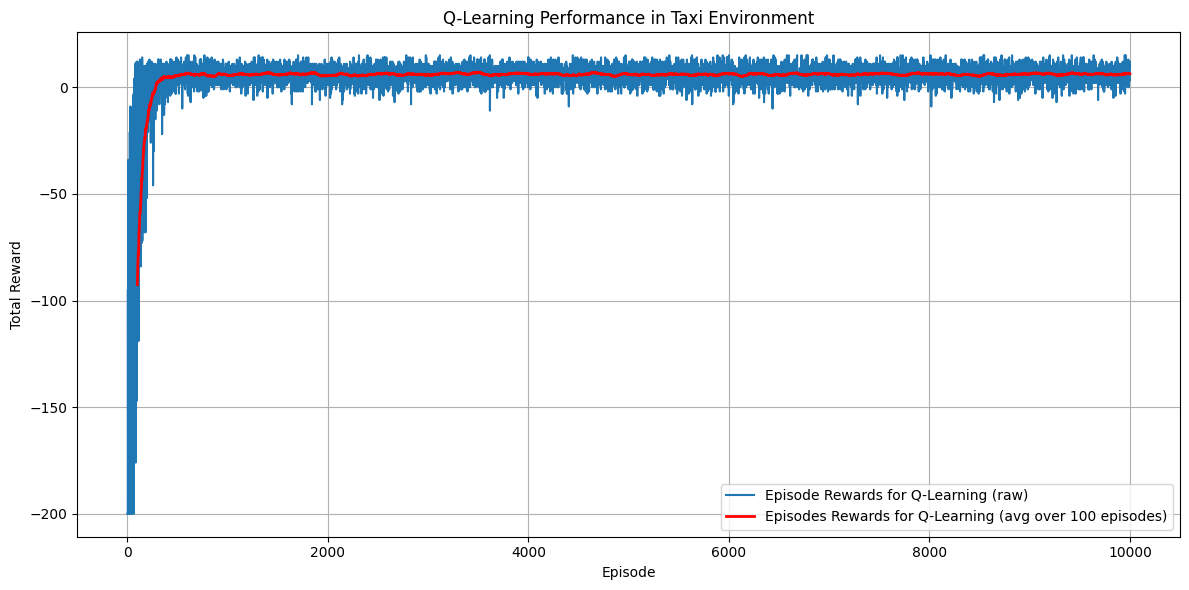

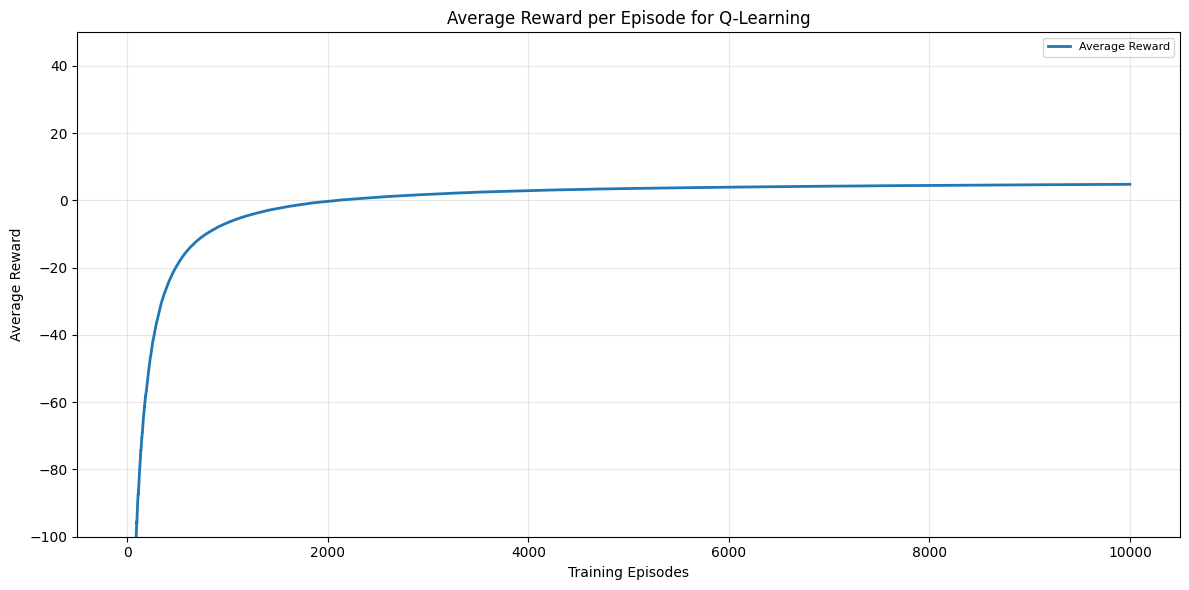

In [30]:
def q_learning(env, alpha = 0.5, gamma = 1, epsilon = 0.1, num_episodes = 10000):
    state_size = env.observation_space.n
    action_size = env.action_space.n
    Q = np.zeros((state_size, action_size))
    rewards_per_episode = []

    for episode in tqdm(range(num_episodes)):
        state, info = env.reset()
        total_reward = 0
        done = False
        while not done:
            action_mask = info.get('action_mask', np.ones(action_size))
            action = select_action(state, Q, action_mask, epsilon)
            next_state, reward, terminated, truncated, info = env.step(action)
            done = terminated or truncated
            if action_mask is not None:
                next_action_mask = info.get('action_mask', np.ones(action_size))
                masked_next_q = np.where(next_action_mask == 1, Q[next_state], -np.inf)
                max_next_q = np.max(masked_next_q)
            else:
                max_next_q = np.max(Q[next_state])
            Q[state, action] += alpha * (reward + gamma * max_next_q - Q[state, action])
            state = next_state
            total_reward += reward
        rewards_per_episode.append(total_reward)
    return Q, rewards_per_episode

q_learning_Q, q_learning_rewards = q_learning(env, alpha=0.5, gamma=1, epsilon=0.1, num_episodes=10000)
plot_learning_curve(q_learning_rewards, algorithm="Q-Learning", window_size=100, title="Q-Learning Performance in Taxi Environment")
plot_average_reward(q_learning_rewards, "Q-Learning", title="Average Reward per Episode for Q-Learning", y_lim=(-100, 50))

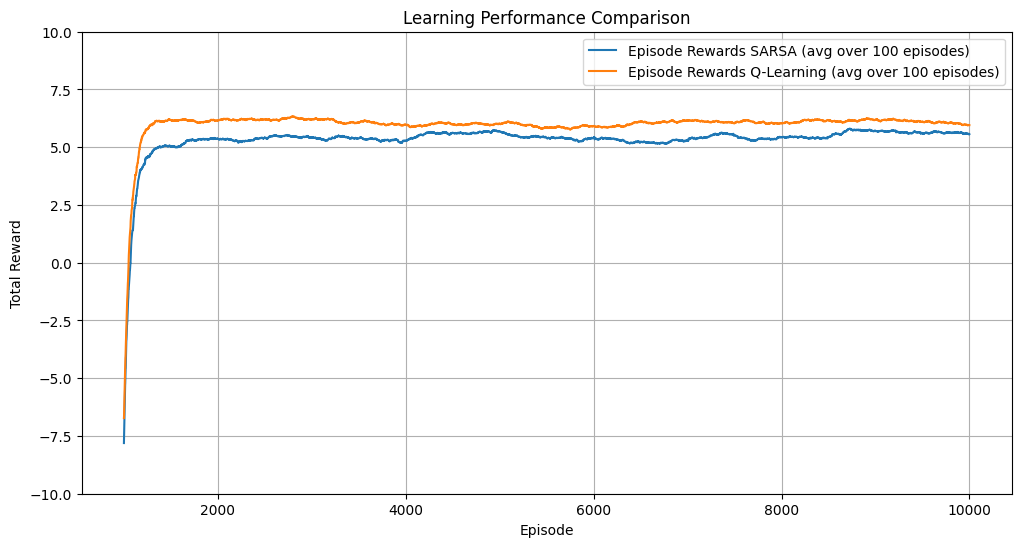

In [25]:

plt.figure(figsize=(12, 6))
smoothed = np.convolve(sarsa_rewards, np.ones(1000)/1000, mode='valid')
plt.plot(range(1000-1, len(sarsa_rewards)), smoothed, label="Episode Rewards SARSA (avg over 100 episodes)")
smoothed = np.convolve(q_learning_rewards, np.ones(1000)/1000, mode='valid')
plt.plot(range(1000-1, len(q_learning_rewards)), smoothed, label="Episode Rewards Q-Learning (avg over 100 episodes)")

plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.ylim(-10, 10)
plt.title("Learning Performance Comparison")
plt.grid(True)
plt.legend()


In [24]:
np.mean(q_learning_rewards)

np.float64(4.7864)

In [11]:
# test the sarsa policy with 100 trials
def test_policy(env, Q, num_trials=100):
    total_rewards = []
    for _ in range(num_trials):
        state, info = env.reset()
        total_reward = 0
        done = False
        while not done:
            action_mask = info.get('action_mask', np.ones(env.action_space.n))
            action = select_action(state, Q, action_mask, epsilon=0.0)
            next_state, reward, terminated, truncated, info = env.step(action)
            done = terminated or truncated
            state = next_state
            total_reward += reward
        total_rewards.append(total_reward)
    return total_rewards

In [12]:
print(np.mean(test_policy(env, sarsa_Q, num_trials=1000)))
np.mean(test_policy(env, q_learning_Q, num_trials=1000))

7.762


np.float64(7.837)

In [ ]:
# signficance test for equal means
sarsa_rewards_test = test_policy(env, sarsa_Q, num_trials=1000)
q_learning_rewards_test = test_policy(env, q_learning_Q, num_trials=1000)
ttest_ind(sarsa_rewards, q_learning_rewards)


TtestResult(statistic=np.float64(8.936002744329818), pvalue=np.float64(4.37756799038062e-19), df=np.float64(19998.0))

(array([ 1.,  1.,  7., 11.,  0., 18., 20., 14., 12.,  0.,  7.,  4.,  3.,
         1.,  1.]),
 array([ 2. ,  2.8,  3.6,  4.4,  5.2,  6. ,  6.8,  7.6,  8.4,  9.2, 10. ,
        10.8, 11.6, 12.4, 13.2, 14. ]),
 <BarContainer object of 15 artists>)

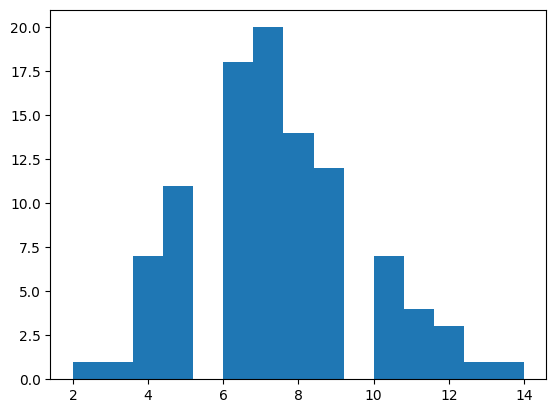

In [14]:
plt.hist(test_policy(env, sarsa_Q, num_trials=100),bins=15, label="SARSA")

In [ ]:
mean1 = np.mean(sarsa_rewards)
mean2 = np.mean(q_learning_rewards)
std1 = np.std(sarsa_rewards, ddof=1)  # Using n-1 for sample standard deviation
std2 = np.std(q_learning_rewards, ddof=1)

# Perform t-test for independent samples
t_stat, p_value = ttest_ind(sarsa_rewards, q_learning_rewards, equal_var=False)
print(f"== Significance Test Results ==")
print(f"SARSA mean reward: {mean1:.2f} ± {std1:.2f}")
print(f"Q-Learning mean reward: {mean2:.2f} ± {std2:.2f}")
print(f"t-statistic: {t_stat:.4f}")
print(f"p-value: {p_value:.4f}")

== Significance Test Results ==
SARSA mean reward: 7.82 ± 2.52
Q-Learning mean reward: 8.02 ± 2.65
t-statistic: -1.6787
p-value: 0.0934


In [ ]:
# median reward for SARSA
print(np.var(sarsa_rewards))
print(np.var(q_learning_rewards))

194.23289799000003
593.85187719


In [ ]:


# Calculate variances
var_sarsa = np.var(sarsa_rewards)
var_ql = np.var(q_learning_rewards)

print("===== ONE-SIDED VARIANCE COMPARISONS =====")
print(f"Variances - SARSA: {var_sarsa}, Q-learning: {var_ql}")

# SARSA vs Q-learning
stat_sarsa_ql, p_value_two_sided_sarsa_ql = levene(sarsa_rewards, q_learning_rewards)
# If SARSA variance is lower, then we can do a one-sided test
p_value_one_sided_sarsa_ql = p_value_two_sided_sarsa_ql / 2 if var_sarsa < var_ql else 1.0
print("\nOne-sided Levene's test (SARSA vs Q-learning, testing if SARSA has lower variance):")
print(f"Test statistic: {stat_sarsa_ql}, two-sided p-value: {p_value_two_sided_sarsa_ql}")
print(f"One-sided p-value: {p_value_one_sided_sarsa_ql}")
print("Significant evidence that SARSA has lower variance" if p_value_one_sided_sarsa_ql < 0.05 else "No significant evidence that SARSA has lower variance")

# SARSA vs Monte Carlo
# If SARSA variance is lower, then we can do a one-sided test

===== ONE-SIDED VARIANCE COMPARISONS =====
Variances - SARSA: 194.23289799000003, Q-learning: 593.85187719

One-sided Levene's test (SARSA vs Q-learning, testing if SARSA has lower variance):
Test statistic: 108.60187631571445, two-sided p-value: 2.304024720010178e-25
One-sided p-value: 1.152012360005089e-25
Significant evidence that SARSA has lower variance


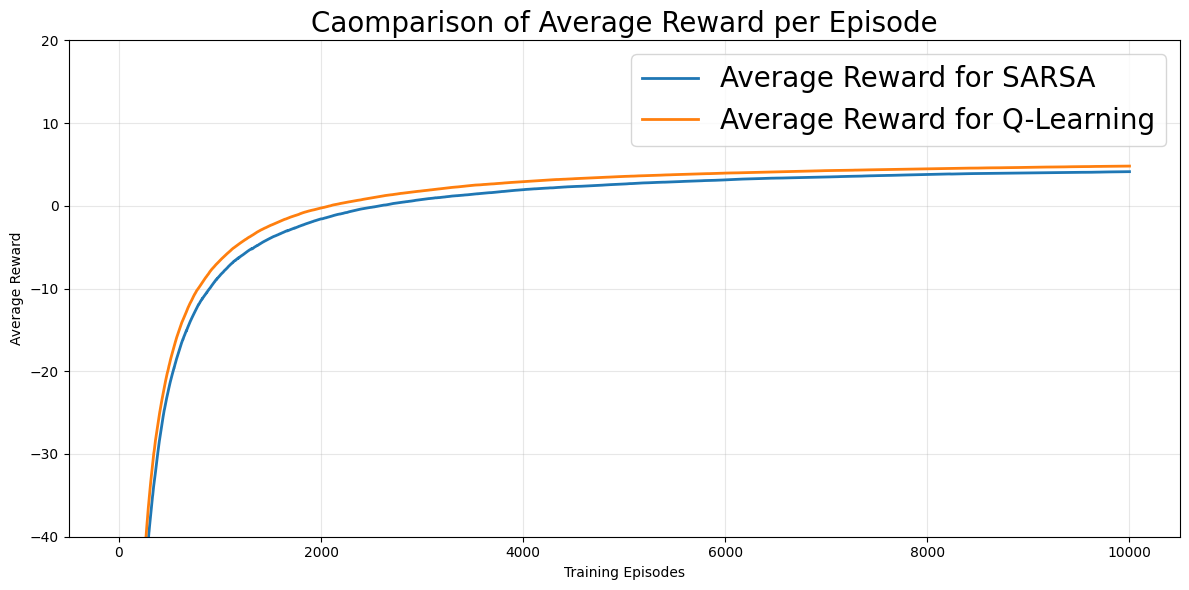

In [ ]:
n = len(sarsa_rewards)
episodes = np.arange(1, n + 1)

# Calculate cumulative averages in one step
sarsa_cumulative_avg = np.cumsum(sarsa_rewards) / episodes
q_learning_cumulative_avg = np.cumsum(q_learning_rewards) / episodes



# Create subplots in 2 rows x 3 columns (adding the new zoomed-in views)
plt.figure(figsize=(12, 6))

# First Row: Average Reward Plots
# Original cumulative average rewards
plt.plot(episodes, sarsa_cumulative_avg, label="Average Reward for SARSA", linewidth=2)
plt.plot(episodes, q_learning_cumulative_avg, label="Average Reward for Q-Learning", linewidth=2)
plt.title(f'Caomparison of Average Reward per Episode', fontsize=20)
plt.ylabel('Average Reward', fontsize=10)
plt.xlabel('Training Episodes', fontsize=10)
plt.ylim(-40, 20)
plt.grid(True, alpha=0.3)
plt.legend(fontsize=20)

plt.tight_layout()
plt.show()